### Trying to determine if the sentiment time series is significantly different from a Random Walk

In [3]:
from rose_wrapper.rose import Rose
import pandas as pd
import datetime
#import yfinance as yf
from pprint import pprint
import os
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize

import re
from nltk import PorterStemmer, WordNetLemmatizer, word_tokenize
#from nltk.corpus import stopwords
from os import listdir
from os.path import isfile, isdir, join
import numpy as np
import numpy
import sys
import getopt
import codecs
import time
import csv
import io
import pickle
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

rose = Rose()
rose.login("krishrao97@gmail.com", "password")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krishnarao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/krishnarao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/krishnarao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
path = '/Users/krishnarao/Desktop/Black Snow/data/financialdata/financial_phrase_bank/'
overallSentimentsNeg = np.load(path + 'overallSentimentsNeg.npy', allow_pickle=True)
overallSentimentsMed = np.load(path + 'overallSentimentsMed.npy', allow_pickle=True)
overallSentimentsPos = np.load(path + 'overallSentimentsPos.npy', allow_pickle=True)

overallSentiments = [overallSentimentsNeg, overallSentimentsMed, overallSentimentsPos]

In [5]:
def getSentiment(x):
    return x.index(max(x))-1

def ccount(arr, val):
    count = 0
    for i in range(len(arr)):
        if val == arr[i]:
            count = count + 1
    return count

def movingAvg(fre, lag, center):
    n = len(fre)
    freRet = []
    tot = 0
    for i in range(n):
        tot = tot + fre[i][1]
        if ((i%lag) == lag-1):
            freRet.append((fre[i][0] - center, tot/lag))
            tot = 0
    return freRet

In [6]:
genericSentiments = overallSentiments 
genericFeels = []
for i in range(len(genericSentiments[0])):
    date = genericSentiments[0][i][0]
    neg = genericSentiments[0][i][1]
    med = genericSentiments[1][i][1]
    pos = genericSentiments[2][i][1]
    ls = []
    for j in range(len(neg)):
        ls.append(getSentiment([neg[j], med[j], pos[j]]))
    genericFeels.append((date, ls))

/Users/krishnarao/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


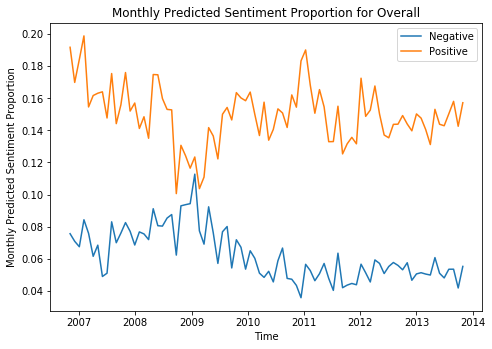

In [7]:
pgenericSentimentsNeg = [] # -q suffix means monthly or weekly
pgenericSentimentsMed = [] # b- prefix means probability
pgenericSentimentsPos = [] # p- prefix means proportion

for i in range(len(genericFeels)):
    date = genericFeels[i][0]
    arr = genericFeels[i][1]
    total = len(arr)
    negCnt = ccount(arr, -1)
    medCnt = ccount(arr, 0)
    posCnt = ccount(arr, 1)
    pgenericSentimentsNeg.append((date, negCnt/total))
    pgenericSentimentsMed.append((date, medCnt/total))
    pgenericSentimentsPos.append((date, posCnt/total))

    if not (negCnt + posCnt + medCnt == total):
        print('ERROR')
        break

period = 30
center = datetime.timedelta(days=14)
pgenericSentimentsNegq = movingAvg(pgenericSentimentsNeg, period, center)
pgenericSentimentsMedq = movingAvg(pgenericSentimentsMed, period, center)
pgenericSentimentsPosq = movingAvg(pgenericSentimentsPos, period, center)
plt.axes([0, 0.6, 1, 1])
plt.plot(*zip(*pgenericSentimentsNegq), *zip(*pgenericSentimentsPosq))
plt.title('Monthly Predicted Sentiment Proportion for ' + 'Overall')
plt.xlabel('Time')
plt.ylabel('Monthly Predicted Sentiment Proportion')
plt.legend(['Negative', 'Positive'])
plt.show()

In [14]:
#pgenericSentimentsPos

### First, look at differences for total data

In [8]:
pos_sent_total = pd.DataFrame(list(pgenericSentimentsPos), columns=['time', 'proportion']).set_index('time')

In [9]:
diff_col_total = pos_sent_total['proportion'].diff()

In [10]:
pos_sent_total['diff'] = diff_col_total

In [11]:
pos_sent_total.head()

,proportion,diff
time,,
2006-10-20,0.127660,NaN
2006-10-21,0.227273,0.099613
2006-10-22,0.153846,-0.073427
2006-10-23,0.204152,0.050306
2006-10-24,0.243902,0.039750


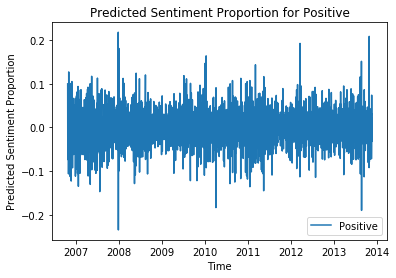

In [12]:
plt.plot(pos_sent_total.index[1:], pos_sent_total['diff'][1:])
plt.title('Predicted Sentiment Proportion for ' + 'Positive')
plt.xlabel('Time')
plt.ylabel('Predicted Sentiment Proportion')
plt.legend(['Positive'])
plt.show()

## Second, look at differences for monthly moving average

In [13]:
pos_sent_monthly = pd.DataFrame(list(pgenericSentimentsPosq), columns=['time', 'proportion']).set_index('time')

In [14]:
diff_col_monthly = pos_sent_monthly['proportion'].diff()

In [15]:
pos_sent_monthly['diff'] = diff_col_monthly

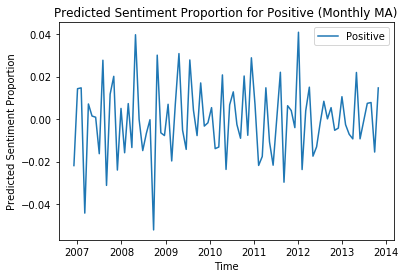

In [18]:
plt.plot(pos_sent_monthly.index[1:], pos_sent_monthly['diff'][1:])
plt.title('Predicted Sentiment Proportion for ' + 'Positive (Monthly MA)')
plt.xlabel('Time')
plt.ylabel('Predicted Sentiment Proportion')
plt.legend(['Positive'])
plt.show()

In [19]:
# Check if st. dev. is smaller for the differences than the overall data

In [25]:
from statsmodels.tsa.stattools import acf, pacf

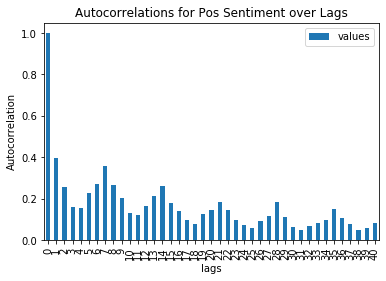

In [26]:
acf_values = acf(pos_sent_total['proportion'], fft = False)
pos_sent_scf = pd.DataFrame({'values': acf_values}, index = range(len(acf_values)))
pos_sent_scf.plot(kind = 'bar')
plt.title('Autocorrelations for Pos Sentiment over Lags')
plt.xlabel('lags')
plt.ylabel('Autocorrelation')
plt.show()
# we know this must be non-stationary because acf would be inconsistent otherwise 

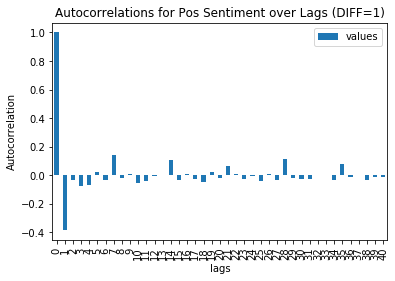

In [28]:
acf_values = acf(pos_sent_total['diff'][1:], fft = False)
pos_sent_scf = pd.DataFrame({'values': acf_values}, index = range(len(acf_values)))
pos_sent_scf.plot(kind = 'bar')
plt.title('Autocorrelations for Pos Sentiment over Lags (DIFF=1)')
plt.xlabel('lags')
plt.ylabel('Autocorrelation')
plt.show()
#differences are probably stationary, which is expected

In [30]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(pos_sent_total['diff'][1:], lags=10, boxpierce=False)[1]

array([2.66309705e-85, 1.34405621e-84, 2.18046448e-86, 8.10216931e-88,
       4.48113970e-87, 1.05555483e-86, 2.82815858e-97, 1.28399124e-96,
       8.98529128e-96, 1.74870516e-96])

In [32]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(pos_sent_total['proportion'], lags=10, boxpierce=False)[1]

array([9.48371355e-091, 6.67744930e-127, 2.93875320e-140, 3.65064847e-152,
       1.89340499e-179, 3.27180066e-219, 5.02500545e-289, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000])

 ## Ljung-Box test  

 
### H0:
The data are independently distributed (i.e. the correlations in the population from which the sample 
is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).
 
### HA:
The data are not independently distributed; they exhibit serial correlation.


### Conclusion: 
For both the original and (DIFF=1) time series, the p-values of the Ljung-Box test statistic are small (<<0.05), so we have evidence to reject the null hypothesis. 
This means that the differenced data must *not* be independently distributed and they exhibit serial correlation. This is also evident in the ACF graphs, where ACF(DIFF=1) shows a pattern.
This observation contrasts with random walks, where the first difference *is* independently distributed (see src2).
The data therefore does not show the properties of a random walk. 

Note: The parameter lag = min(10, T/5), where T is length of time series, is recommended for non-seasonal data seasonality (src1). lag = min (10, 258.8) in this case.

src1: https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test

src2: https://people.duke.edu/~rnau/Notes_on_the_random_walk_model--Robert_Nau.pdf

src3: https://robjhyndman.com/hyndsight/ljung-box-test/


258.8